# Introduction
Physics-Informed Neural Networks (PINNs) represent a novel approach to solving partial differential equations (PDEs) by incorporating the physical laws described by the equations into the loss function of the neural network. Unlike traditional numerical methods, PINNs do not require a discretization to solve PDEs and can work with scattered data, making them highly flexible. This tutorial demonstrates the implementation of a PINN to solve the one-dimensional diffusion equation using PyTorch.

### Requirements
- Pytorch (see https://pytorch.org/ for intallation on your system)
- NumPy
- Matplotlib

### The Diffusion Equation
The diffusion equation is a fundamental equation in physics describing the distribution of heat (or variation of temperature) in a given region over time. For a one-dimensional rod, the equation is given by:



\begin{aligned}
\frac{\partial^2 u(x, t)}{\partial x^2} = \frac{\partial u(x, t)}{\partial t}, \quad t > 0, x \in [0, L],
\end{aligned}


where $u(x, t)$ denotes the temperature at position $x$  and time $t$ , and $L$  is the length of the rod.

### Initial and Boundary Conditions

The initial condition at \( t = 0 \) is:

\begin{aligned}
u(x, 0) = \sin(\pi x), \quad 0 < x < L
\end{aligned}

The boundary conditions are defined as:

\begin{aligned}
u(0, t) = 0, \quad t \geq 0
\end{aligned}

\begin{aligned}
u(L, t) = 0, \quad t \geq 0
\end{aligned}

# Setting up the Neural Network

We import the necessary packages and define a neural network class `PINN` that inherits from `torch.nn.Module`. The network architecture is defined as a fully-connected neural network with an input layer, several hidden layers with a SiLU activation function. The weights are initialized using the Xavier uniform initialization method.

The `forward` method in the `PINN` class defines the forward pass of the neural network, which computes the output given the input.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

In [14]:
class PINN(nn.Module):
    """
    A Physics-Informed Neural Network (PINN) module for solving the diffusion equation.
    """
    def __init__(self, num_inputs, num_layers, num_neurons, device):
        """
        Initialize the PINN model.

        Parameters:
        num_inputs (int): Number of input features.
        num_layers (int): Number of hidden layers.
        num_neurons (int): Number of neurons in each hidden layer.
        device (torch.device): The device on which to perform computations.
        """
        super(PINN, self).__init__()
        self.device = device
        num_layers = num_layers
        num_neurons = num_neurons
        activation = nn.SiLU()

        layers = [nn.Linear(num_inputs, num_neurons), activation] # Input layer
        for _ in range(num_layers ):
            layers += [nn.Linear(num_neurons, num_neurons), activation] # Hidden layers
        layers += [nn.Linear(num_neurons, 1)] # Output layer

        self.model = nn.Sequential(*layers).to(device) #Create the model by stacking the layers sequentially and move to device
        # Initialize weights using Xavier uniform initialization and biases to zero
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)
                torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
            """
            Perform a forward pass of the PINN model.

            Parameters:
            x (torch.Tensor): The input tensor containing the spatial and temporal coordinates.

            Returns:
            torch.Tensor: The output of the neural network, representing the solution u(x, t) of the PDE at input points.
            """
            return self.model(x)

# Loss Function

In Physics-Informed Neural Networks, the loss function is a composite of the mean squared errors of the residuals from the governing Partial Differential Equation (PDE) and the initial and boundary conditions (IC/BC). The overall loss function $\mathcal{L}_{total}$ is expressed as:

- **PDE Loss**: The PDE loss $\mathcal{L}_{PDE}$ is based on the PDE residual $R_{PDE}$, which is the discrepancy between the predicted temporal derivative $u_t$ and the second spatial derivative $u_{xx}$:
$$ \mathcal{L}_{PDE} = \frac{1}{N_{pde}} \sum_{i=1}^{N_{pde}} \left(R_{PDE}(x_i, t_i)\right)^2 = \frac{1}{N_{pde}} \sum_{i=1}^{N_{pde}} \left(u_t(x_i, t_i) - u_{xx}(x_i, t_i)\right)^2 $$

- **Initial Condition Loss**: The initial condition loss $\mathcal{L}_{IC}$ comes from the residual $R_{IC}$ at $t = 0$:
$$ \mathcal{L}_{IC} = \frac{1}{N_{ic}} \sum_{i=1}^{N_{ic}} \left(R_{IC}(x_i)\right)^2 = \frac{1}{N_{ic}} \sum_{i=1}^{N_{ic}} \left(u(x_i, 0) - \sin(\pi x_i)\right)^2 $$

- **Boundary Condition Loss**: The losses for the left $\mathcal{L}_{BC_{left}}$ and right $\mathcal{L}_{BC_{right}}$ boundary conditions are based on the residuals $R_{BC_{left}}$ and $R_{BC_{right}}$ at $x = 0$ and $x = L$, respectively:
$$ \mathcal{L}_{BC_{left}} = \frac{1}{N_{bc}} \sum_{i=1}^{N_{bc}} \left(R_{BC_{left}}(t_i)\right)^2 = \frac{1}{N_{bc}} \sum_{i=1}^{N_{bc}} \left(u(0, t_i)\right)^2 $$
$$ \mathcal{L}_{BC_{right}} = \frac{1}{N_{bc}} \sum_{i=1}^{N_{bc}} \left(R_{BC_{right}}(t_i)\right)^2 = \frac{1}{N_{bc}} \sum_{i=1}^{N_{bc}} \left(u(L, t_i)\right)^2 $$

- **Total Loss**: The total loss is simply the sum of the individual components:
$$ \mathcal{L}_{total} = \mathcal{L}_{PDE} + \mathcal{L}_{IC} + \mathcal{L}_{BC_{left}} + \mathcal{L}_{BC_{right}} $$

The training objective is to minimize $\mathcal{L}_{total}$, prompting the network to learn an approximation to the PDE's solution that adheres to the given initial and boundary conditions.

### PDE loss term

To enforce the diffusion equation as a constraint in the neural network, we need to compute the temporal and spacial derivatives of the networks outputs.`torch.autograd` enables the computation of these derivatives efficiently.

In [15]:
def pde( x, model):
    """
    Calculate the residual of the diffusion equation for use in the loss function.

    This function computes the residual of the one-dimensional diffusion equation. 

    

    Parameters:
    x (torch.Tensor): The input tensor containing spatial and temporal coordinates.
                      The first column should be the spatial coordinate and the second
                      column the temporal coordinate.
    model (torch.nn.Module): The neural network model used for prediction. 

    Returns:
    torch.Tensor: The residual of the diffusion equation.
    """
    x_space = x[:, 0:1] #Spacial coordinates
    x_time = x[:, 1:2] #Temporal coordinates

    # Enable gradient tracking for x_space and x_time
    x_space.requires_grad_(True)
    x_time.requires_grad_(True)

    # Predict the function u using the model
    u = model(torch.cat((x_space, x_time), dim=1))

    # Compute the first spatial derivative of u
    u_x = torch.autograd.grad(
        u, x_space, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    # Compute the second spatial derivative of u
    u_xx = torch.autograd.grad(
        u_x, x_space, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    # Compute the temporal derivative of u
    u_t = torch.autograd.grad(
        u, x_time, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    return u_t - u_xx

### IC and BC
Next we set up the initial and boundary conditions. Note that we implement these as "soft" constraints (as loss terms), in contrast to the "hard" constraints discussed in the FYS-STK3155/4155 material, where boudary and initial conditions are imposed in a trial function.

In [16]:
def IC( x,model):
    """
    Calculate the loss for the initial condition.

    This function computes the difference between the model's prediction and the expected 
    value of the solution at the initial time (t = 0). In this case, the expected value is u(x, 0) = sin(pi*x).

    Parameters:
    x (torch.Tensor): The input tensor containing the spatial and time coordinates.
    model (torch.nn.Module): The neural network model used for prediction.
    
    Returns:
    torch.Tensor: The loss for the initial condition.
    """
    u0 = model(x)

    return u0-torch.sin(np.pi*x[:, 0:1])

def BC_left(x, model):
    """
    Calculate the loss for the left boundary condition.

    This function computes the difference between the model's prediction and the expected 
    value of the solution at the left boundary (x = 0). In this case, the expected value is u(0,t)=0.

    Parameters:
    x (torch.Tensor): The input tensor containing the spatial and time coordinates.
    model (torch.nn.Module): The neural network model used for prediction.

    Returns:
    torch.Tensor: The loss for the left boundary condition.
    """
    u_left = model(x)

    return u_left

def BC_right(x, model):
    """
    Calculate the loss for the right boundary condition.

    This function computes the difference between the model's prediction and the expected 
    value of the solution at the right boundary (x = L). In this case, the expected value is u(L,t)=0.

    Parameters:
    x (torch.Tensor): The input tensor containing the spatial and time coordinates.
    model (torch.nn.Module): The neural network model used for prediction.

    Returns:
    torch.Tensor: The loss for the right boundary condition.
    """
    u_right = model(x)
    return u_right


### Training step

Before computing the loss,backpropagating and updating the parameters, we reset the gradients accumulated in the optimizer by calling `optimizer.zero_grad`. This is a standard step in training neural networks with pytorch, as gradients are accumulated by default.


In [17]:
def train_step( X_left, X_right, X_collocation, X_ic, optimizer, model):
    """
    Perform a single training step.

    This function performs a single training step of the PINN model. It calculates the loss and its gradients, 
    
    Parameters: 
    X_left (torch.Tensor): The input tensor containing the spatial and time coordinates of the left boundary.
    X_right (torch.Tensor): The input tensor containing the spatial and time coordinates of the right boundary.
    X_collocation (torch.Tensor): The input tensor containing the spatial and time coordinates of the collocation points.
    X_ic (torch.Tensor): The input tensor containing the spatial and time coordinates of the initial condition.
    optimizer (torch.optim.Optimizer): The optimizer used for gradient descent.
    model (torch.nn.Module): The neural network model used for prediction.
    
    Returns:
    torch.Tensor: The loss for the PDE, the loss for the initial condition, the loss for the left boundary condition,
                  the loss for the right boundary condition, and the total loss.
                  
    """
    optimizer.zero_grad() # Reset gradients

    IC_loss = torch.mean(torch.square(IC(X_ic,model)))
    BC_left_loss = torch.mean(torch.square(BC_left(X_left,model)))
    BC_right_loss = torch.mean(torch.square(BC_right(X_right,model)))
    pde_loss = torch.mean(torch.square(pde(X_collocation,model)))
    loss = IC_loss + BC_left_loss + BC_right_loss + pde_loss
    loss.backward() # Backpropagate loss

    
    optimizer.step() # Update weights

    return pde_loss, IC_loss, BC_left_loss, BC_right_loss, loss

In [18]:
def analytical_solution(x):
    """
    Calculate the analytical solution to the diffusion equation.
    """
    return np.exp(-np.pi**2*x[:, 1:2])*np.sin(np.pi*x[:, 0:1])

### Setting up the Device and Generating Training Data

First, we set up the device (CPU or GPU) for computation. The following code demonastrates setting up the device with `cuda` if an NVIDIA GPU is available.

PyTorch also supports Apple silicone devices (MPS). For more info see: https://developer.apple.com/metal/pytorch/


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We generate a grid of points in the spacial and temporal domain. These points will be used for training the neural network and enforcing the PDE, IC and BCs.

In [20]:
# Generate training data
N_space = 20
N_time = 20
# Define the spatial and temporal coordinates of the training data
x_space = np.linspace(0, 1, N_space)
x_time = np.linspace(0, 1, N_time)
# Remove the boundary points from the collocation points (Used for evaluating the PDE)
x_collocation = x_space[1:-1]
t_collocation = x_time[1:-1]
# Meshgrid for collocation points
x_collocation, t_collocation = np.meshgrid(x_collocation, t_collocation)
x_collocation = x_collocation.reshape(-1, 1)
t_collocation = t_collocation.reshape(-1, 1)
X_collocation = np.hstack((x_collocation, t_collocation))
# Convert the coordinates to tensors on the chosen device
X_collocation = torch.tensor(
    X_collocation, dtype=torch.float32, device=device)



# Define the initial condition coordinates
t_ic = np.zeros_like(x_space)
x_ic = x_space
# Reshape the coordinates to be column vectors
x_ic = x_ic.reshape(-1, 1)
t_ic = t_ic.reshape(-1, 1)
# Combine the spatial and temporal coordinates
X_ic = np.hstack((x_ic, t_ic))
# Convert the coordinates to tensors on the chosen device
X_ic = torch.tensor(X_ic, dtype=torch.float32, device=device)

# Define the left and right boundary coordianates
x_left = x_space[0]*np.ones_like(x_space)
t_left = x_time
x_left = x_left.reshape(-1, 1)
t_left = t_left.reshape(-1, 1)
X_left = np.hstack((x_left, t_left))
X_left = torch.tensor(X_left, dtype=torch.float32, device=device)

x_right = x_space[-1]*np.ones_like(x_space)
t_right = x_time
x_right = x_right.reshape(-1, 1)
t_right = t_right.reshape(-1, 1)
X_right = np.hstack((x_right, t_right))
X_right = torch.tensor(X_right, dtype=torch.float32, device=device)

### Initializing the model and training
We initialize the Physics-Informed Neural Network model and set up the optimizer. The model has 4 hidden layers with 32 nodes and we use the Adam optimizer with a learning rate lr=1e-2. We also use an exponential decay learning rate scheduler.

In [21]:
# Initialize model
model = PINN(num_inputs=2, num_layers=2, num_neurons=32, device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
# Exponential decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

### Training
We are now ready to train our model. In each epoch, the PDE, initial, and boundary condition losses are computed, combined, and used to update the model parameters. The learning rate is reduced every 100 epochs.

Epoch 0, pde 2.0560e-03 , IC 4.8660e-01, BC_left 6.0259e-04, BC_right 1.8545e-03, loss 4.9111e-01


Epoch 100, pde 8.9333e-03 , IC 2.2483e-02, BC_left 6.8855e-03, BC_right 4.7442e-03, loss 4.3046e-02
Epoch 200, pde 1.0946e-03 , IC 1.9870e-04, BC_left 8.6569e-05, BC_right 9.2150e-05, loss 1.4720e-03
Epoch 300, pde 6.2379e-04 , IC 3.8558e-05, BC_left 2.4903e-05, BC_right 2.0715e-05, loss 7.0797e-04
Epoch 400, pde 4.6670e-04 , IC 2.3245e-05, BC_left 1.4721e-05, BC_right 1.0505e-05, loss 5.1517e-04
Epoch 500, pde 7.9898e-04 , IC 1.1758e-04, BC_left 1.6747e-05, BC_right 2.4825e-05, loss 9.5813e-04
Epoch 600, pde 2.9950e-04 , IC 9.1602e-06, BC_left 7.5472e-06, BC_right 5.7062e-06, loss 3.2191e-04
Epoch 700, pde 4.5967e-04 , IC 1.2617e-04, BC_left 1.1912e-05, BC_right 2.2130e-05, loss 6.1988e-04
Epoch 800, pde 2.0864e-04 , IC 4.5778e-06, BC_left 4.9641e-06, BC_right 4.8931e-06, loss 2.2308e-04
Epoch 900, pde 1.6388e-04 , IC 3.3474e-06, BC_left 4.0327e-06, BC_right 4.6811e-06, loss 1.7594e-04
Epoch 1000, pde 3.4679e-03 , IC 1.0419e-03, BC_left 6.0647e-05, BC_right 8.9398e-05, loss 4.6598e-03

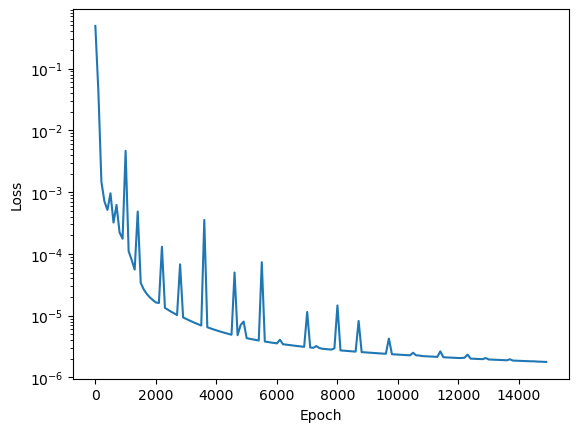

In [22]:
# Train model
epochs = 15000 # Number of training iterations (This might be a bit high/slow if you are using a CPU)
#Listis to store the loss and epoch
loss_list = []
epoch_list = []

# Train model
for epoch in range(epochs):
    pde_loss, IC_loss, BC_left_loss, BC_right_loss,loss_total = train_step(
        X_left, X_right, X_collocation, X_ic, optimizer,model)
    
    if epoch % 100 == 0:
        loss_list.append(loss_total.item())
        epoch_list.append(epoch)
        scheduler.step() # Update learning rate
        print(f'Epoch {epoch}, pde {pde_loss.item():.4e} , IC {IC_loss.item():.4e}, BC_left {BC_left_loss.item():.4e}, BC_right {BC_right_loss.item():.4e}, loss {loss_total.item():.4e}')

# Plot loss
plt.plot(epoch_list, loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Now that we have our trained model, we can use it to predict and visualize the results. Note that although we have only used $20\times 20$ for training, we can now evaluate our model using an arbitrarily larger number of points. This showcases one of the great advantages of using a neural networks to solve differential equations, namely interpolation.

In [23]:
# Generate data for plotting
N_space_plot = 100
N_time_plot = 100
x_space_plot = np.linspace(0, 1, N_space_plot)
x_time_plot = np.linspace(0, 1, N_time_plot)
x_space_mesh, x_time_mesh = np.meshgrid(x_space_plot, x_time_plot)
x_space_flat = x_space_mesh.reshape(-1, 1)
x_time_flat = x_time_mesh.reshape(-1, 1)
x = np.hstack((x_space_flat, x_time_flat))
x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
analytical = analytical_solution(x).reshape(N_space_plot, N_time_plot)

- When plotting, we need to work with either NumPy arrays or standard data structures like lists. Pytorch tensors are not directly compatible with Matplotlib's functions. Therefore, we have to convert the tensor to a NumPy array using `.numpy()`. 
- Additionally, PyTorch tensors used in model training are typically part of a computational graph, which is necessary for gradient computation during backpropagation. However, for plotting, gradient computation is irrelevant. Using `.detach()` removes the tensor from the computational graph, ensuring that unnecessary computational resources are not used. 
- If your PyTorch model is running on a GPU, the tensors containing the model's outputs will also be on the GPU. Matplotlib, however, does not support plotting directly from GPU tensors. The `.cpu()` method ensures that the data is transferred back to the CPU, where Matplotlib can access and plot it.

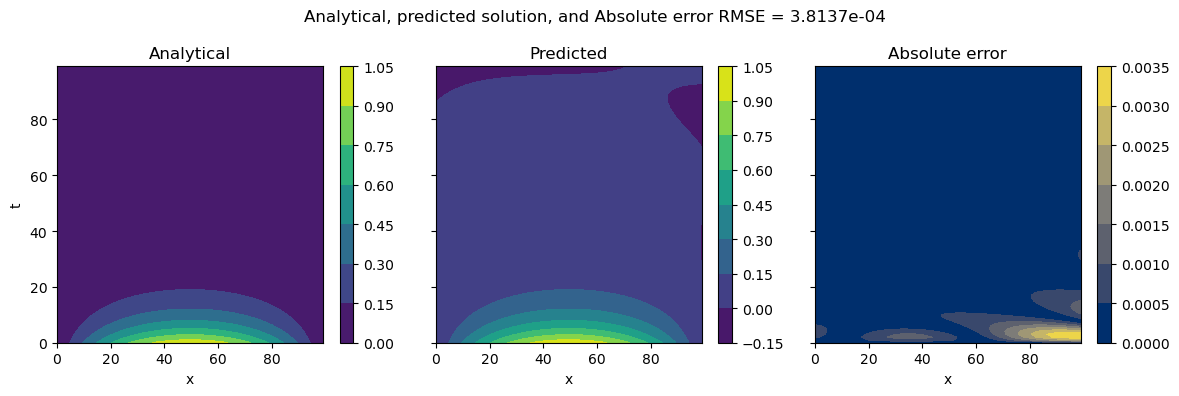

In [24]:

y_pred = model(x_tensor).detach().cpu().numpy().reshape(N_space_plot, N_time_plot)

# Plot prediction and analytical in subplots
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
fig.suptitle('Analytical and predicted solution')
c0=axs[0].contourf(analytical)
axs[0].cb = plt.colorbar(c0, ax=axs[0])
axs[0].set_title('Analytical')
axs[0].set_ylabel('t')
axs[0].set_xlabel('x')
c1=axs[1].contourf(y_pred)
axs[1].cb = plt.colorbar(c1, ax=axs[1])
axs[1].set_title('Predicted')
axs[1].set_xlabel('x')
c2=axs[2].contourf(np.abs(analytical-y_pred),cmap='cividis')
axs[2].cb = plt.colorbar(c2, ax=axs[2])
axs[2].set_title('Absolute error')
axs[2].set_xlabel('x')
RMSE = np.sqrt(np.mean((analytical-y_pred)**2))
# RMSE in title
fig.suptitle(f'Analytical, predicted solution, and Absolute error RMSE = {RMSE:.4e}')
plt.tight_layout()
plt.show()